## Code Wavelet Transform

Par Réjane Joyard

### Importation des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pywt
import os
import matplotlib.patches as patches
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import norm
from numpy.fft import rfft, rfftfreq

### Chargement de la donnée et de ces paramètres

In [2]:
filename = ('POC001FoxG1creGjb2floxflox-souris114OD-143734-40kHz-abr_res.mat')
data = loadmat(filename)
cson = 340
t0 = 1e-3 * data['stimparams']['espace'][0][0][0][0] / 2
ttube = 0.08 / cson
time = 1e3 * (data['tt1'] - t0 - ttube)
time = time[:,0]
gain = 1e4
hrfac = 1e6 / gain
h = hrfac * np.array(data['hravsing'])
h = h - np.mean(h, axis=0)
signal = h[:,0]

### Wavelet VS Fourier Transform

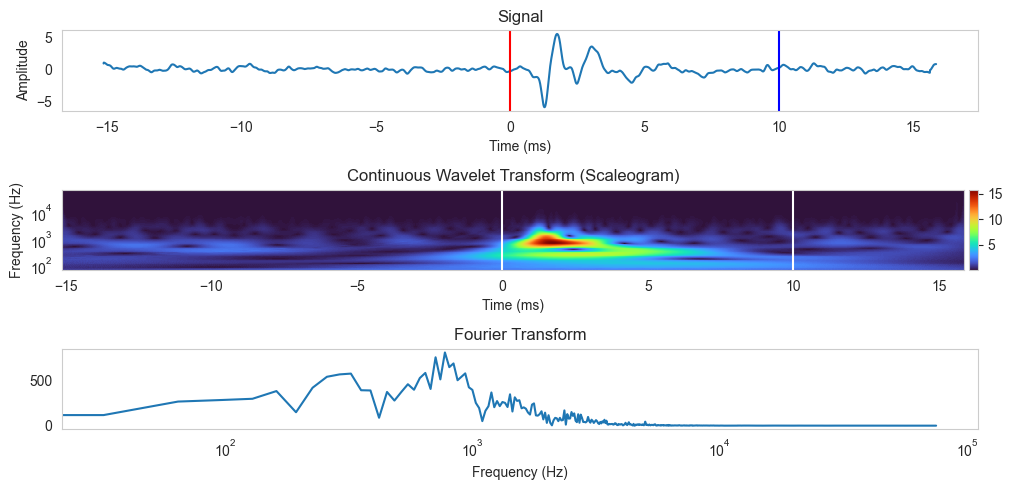

In [3]:
# Partie Wavelet
wavelets = "cmor2.5-0.5" # type de wavelet
widths = np.geomspace(1, 1024, num=100)
fs = 150*1e3 # fréquence
sampling_period = 1/fs
cwtmatr, freqs = pywt.cwt(signal, widths, wavelets, sampling_period=sampling_period) # application de la transformée
cwtmatr = np.abs(cwtmatr)

# Affichage du signal 90 dB
fig, axs = plt.subplots(3, 1, figsize=(10,5))
axs[0].plot(time, signal)
axs[0].set_title('Signal')
axs[0].set_ylabel("Amplitude")
axs[0].set_xlabel("Time (ms)")
axs[0].axvline(0, color='r')
axs[0].axvline(10, color='b')
axs[0].grid(False)

# Affichage Wavelet
pcm = axs[1].pcolormesh(time, freqs, cwtmatr,cmap='turbo')
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title("Continuous Wavelet Transform (Scaleogram)")
axs[1].grid(False)
axs[1].axvline(0, color='white')
axs[1].axvline(10, color='white')

# Calcul et affichage de la transformée de Fourier
y_f = rfft(signal)
x_f = rfftfreq(len(signal), sampling_period)
plt.semilogx(x_f, np.abs(y_f))
axs[2].set_xlabel("Frequency (Hz)")
axs[2].set_title("Fourier Transform")
axs[2].grid(False)
plt.tight_layout()
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="1%", pad=0.05)
fig.colorbar(pcm, cax=cax)

### Fonction Wavelet

In [8]:
def calculer_seuil_wavelet(h, widths, wavelets, sampling_period, time):
    plt.figure(figsize=(15, 20))

    # Paramètres 
    intervalle = np.arange(90, 0, -10)
    
    # Initialisation des boxes
    amplitude_means = []
    box1 = []
    box2 = []
    box3 = []

    # Boucle d'affichage
    for i in range(h.shape[1]):
        print(f"Niveau d'intensité: {intervalle[i]} dB")
        # Récupération du signal 
        signal = h[:, i]

        # Transformée en ondelettes
        cwtmatr, freqs = pywt.cwt(signal, widths, wavelets, sampling_period=sampling_period)
        cwtmatr = np.abs(cwtmatr)
        
        # Affichage de chaque transformée en ondelettes
        plt.subplot(9, 1, i+1)
        pcm = plt.pcolormesh(time, freqs, cwtmatr, cmap='turbo')
        plt.axis('tight')
        plt.axvline(x=0, color='w')
        plt.axvline(x=10, color='w')
        plt.yscale('log')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title(f'{intervalle[i]} dB')
        plt.subplots_adjust(hspace=0.7)
        fig.colorbar(pcm)

        # Position des boxes
        boxes = [(-7, -3, 400, 5000), (0.5, 4.5, 400, 5000), (10, 14, 400, 5000)]
        colors = ['r', 'r', 'r']
        
        row_means = []
        for j, (start_time, end_time, start_freq, end_freq) in enumerate(boxes):
            # Création des box
            plt.gca().add_patch(patches.Rectangle((start_time, start_freq), end_time - start_time, end_freq - start_freq, linewidth=1, edgecolor=colors[j], facecolor='none'))
            
            # Amplitudes dans les box
            time_indices = np.where((start_time <= time) & (time <= end_time))[0]
            freq_indices = np.where((start_freq <= freqs) & (freqs <= end_freq))[0]
            amplitudes_in_box = np.abs(cwtmatr[np.ix_(freq_indices, time_indices)])
            mean_amplitude = np.mean(amplitudes_in_box)
            row_means.append(mean_amplitude)
            
            # Remplir les boxes des amplitudes récupérées
            if j == 0:
                box1.append(amplitudes_in_box)
            if j == 1:
                box2.append(amplitudes_in_box)
            if j == 2:
                box3.append(amplitudes_in_box)
        
        amplitude_means.append(row_means)

    plt.tight_layout()
    plt.show()
    
    # Calcul de la box 4
    sums = []
    for i in range(len(box1)):
        sum = (box1[i] + box3[i]) / 2
        sums.append(sum)
    
    # Création d'un tableau pandas 
    columns = ['Box 1 (-7 to -3 ms)', 'Box 2 (0 to 5 ms)', 'Box 3 (10 to 14 ms)']
    df = pd.DataFrame(amplitude_means, columns=columns)
    df['Mean of Sum (Box 1 + Box 3)'] = np.mean(np.mean(sums, axis=1), axis=1)
    std_mean_of_sum = np.std(np.std(sums, axis=1), axis=1)
    risk = 1e-5 # à modifier 
    df['Condition (Mean of Sum > Box 2)'] = ((df['Mean of Sum (Box 1 + Box 3)'] + norm.ppf(1-risk,0,1) * std_mean_of_sum) < df[columns[1]]).astype(int)
    
    # Paramètres et données pour le calcul d'interpolation des moyennes
    mean_of_sum = df['Mean of Sum (Box 1 + Box 3)'] + norm.ppf(1-risk,0,1) * std_mean_of_sum
    box2_mean = df['Box 2 (0 to 5 ms)']
    i_values = np.arange(len(mean_of_sum))
    dB = np.arange(90, -1, -10)[:-1]
    
    # Conversion en array
    i_values = np.array(i_values)
    mean_of_sum = np.array(mean_of_sum)
    box2_mean = np.array(box2_mean)
    
    # Delta
    difference = mean_of_sum - box2_mean
    cross_indices = np.where(np.diff(np.sign(difference)))[0]
    
    # Calcul de l'interpolation et affichage des courbes de moyennes
    x_cross_dB = 0
    if len(cross_indices) > 0:
        index = cross_indices[0]
        x1, x2 = i_values[index], i_values[index + 1]
        y1, y2 = difference[index], difference[index + 1]
        x_cross = x1 - y1 * (x2 - x1) / (y2 - y1)
    
        dB1, dB2 = dB[index], dB[index + 1]
        x_cross_dB = dB1 + (dB2 - dB1) * (x_cross - x1) / (x2 - x1)
        y_cross = mean_of_sum[index] + (x_cross - x1) * (mean_of_sum[index + 1] - mean_of_sum[index]) / (x2 - x1)
    plt.plot(i_values, mean_of_sum, label='Mean of Sum (Box 1 + Box 3)')
    plt.plot(i_values, box2_mean, label='Box 2 (0 to 5 ms)')
    
    # Afficher le point de croisement
    if x_cross is not None and y_cross is not None:
        plt.scatter(x_cross, y_cross, color='red', zorder=5)
        plt.annotate(f'({x_cross:.2f}, {y_cross:.2f})', (x_cross, y_cross), textcoords="offset points", xytext=(10,10), ha='center')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Mean of Sum vs Box 2')
    plt.legend()
    plt.grid(False)
    plt.show()
    
    # La fonction retourne x_cross_dB sinon None
    if x_cross_dB is not None:
        return x_cross_dB
    else:
        return None

### Application de la fonction à la donnée

Niveau d'intensité: 90 dB
Niveau d'intensité: 80 dB
Niveau d'intensité: 70 dB
Niveau d'intensité: 60 dB
Niveau d'intensité: 50 dB
Niveau d'intensité: 40 dB
Niveau d'intensité: 30 dB
Niveau d'intensité: 20 dB
Niveau d'intensité: 10 dB


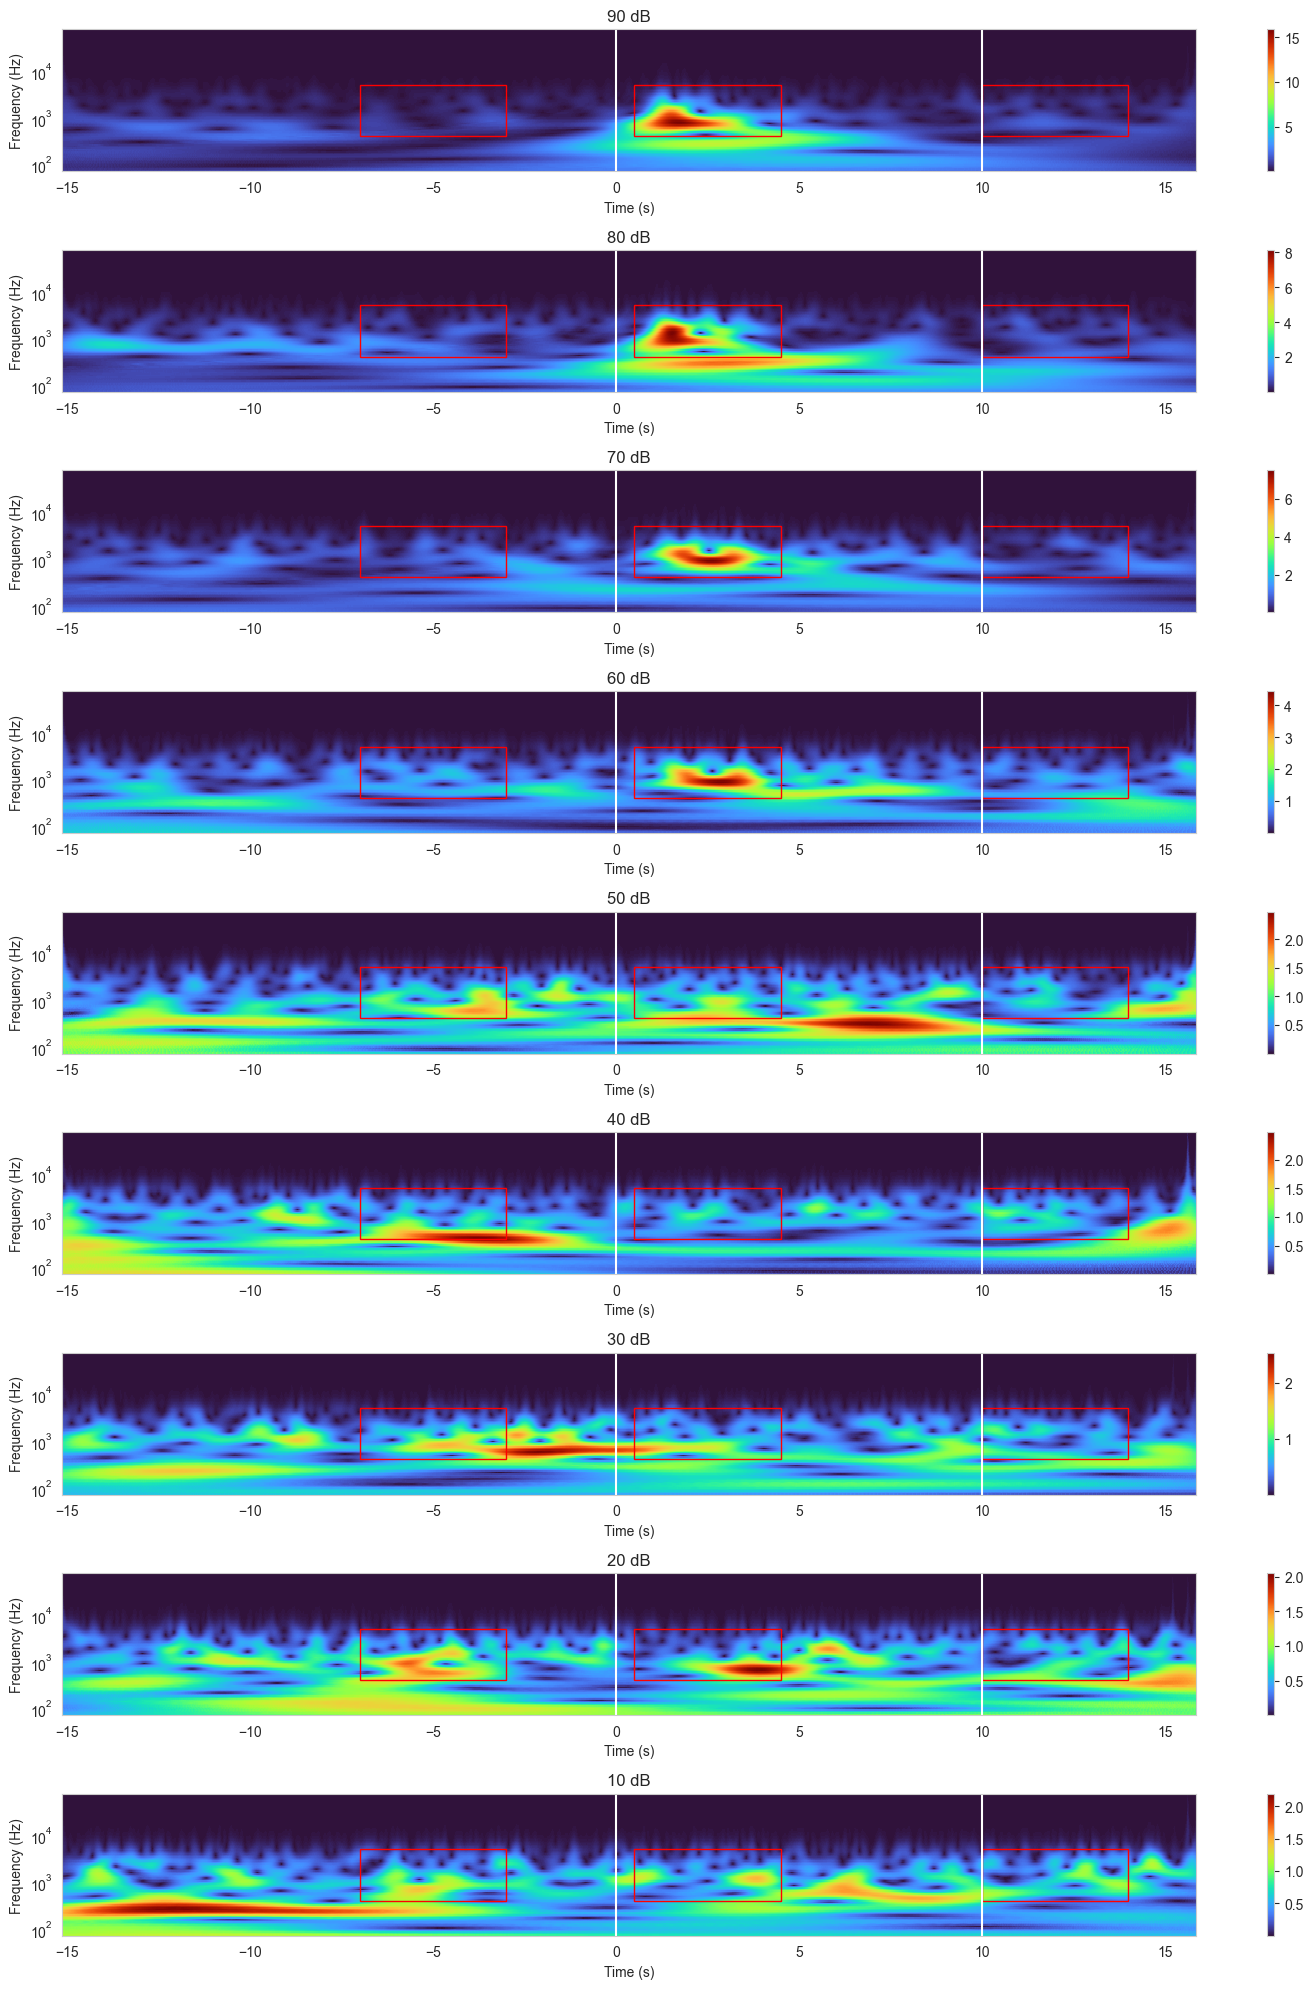

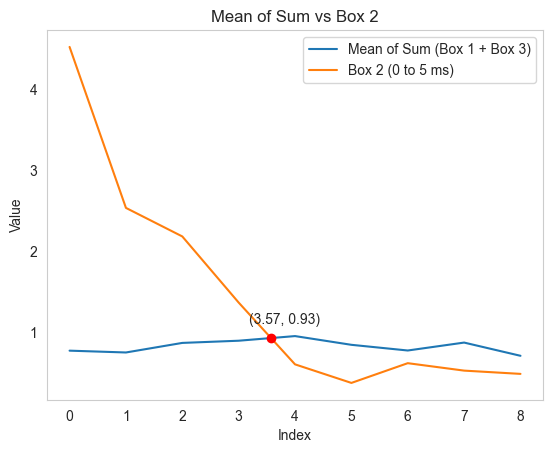

54.25659647257089

In [9]:
calculer_seuil_wavelet(h, widths, wavelets, sampling_period, time)